Обязательные переменные:
1. money – стартовое количество денежных единиц ( 1 000 000 )
2. start – дата старта временного интервала (2015-1-1)
3. finish – дата финиша временного интервала (2020-12-31)
4. stop_loss – в процентах (5%)
5. short_window – размер короткого скользящего окна (30 торговых дней)
6. long_window – размер короткого скользящего окна (90 торговых дней)


В окнах считаем простое среднее

Сигнал покупки - sig_buy - скользящая короткая пробивает вверх скользящую длинную.

Сигнал продажи - sig_sale - скользящая короткая пробивает вниз скользящую длинную.

На следующий день, по цене открытия формируется покупка (buy) или продажа (sale). Покупка идет
на все деньги, имеющиеся в данный момент на счете, на целое и при этом максимально возможное
количество бумаг.
При покупке фиксируется стоп-лосс. При пробитии стоп-лосса вниз внутри любого
дня (даже дня
покупки) фиксируются убытки, осуществляется продажа по цене срабатывания стоп-лосса. Важно
понимать, что иногда, при определенных условиях, цена продажи при выпадении стоп-лосса может
оказаться существенно ниже стоп-лосса.

При продаже всегда продается весь объем

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import plotly.graph_objects as go

In [2]:
money = 1000000
start = '2015-1-1'
finish = '2020-12-31'
stop_loss = 0.05
short_window = 30
long_window = 90

In [3]:
tab = yf.download('BABA', start=start, end=finish)
tab=tab.drop(['Volume'],axis=1)
tab.columns = tab.columns.droplevel(1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
ma_30 = tab['Close'].rolling(window=short_window).mean()
ma_90 = tab['Close'].rolling(window=long_window).mean()

<Axes: xlabel='Date'>

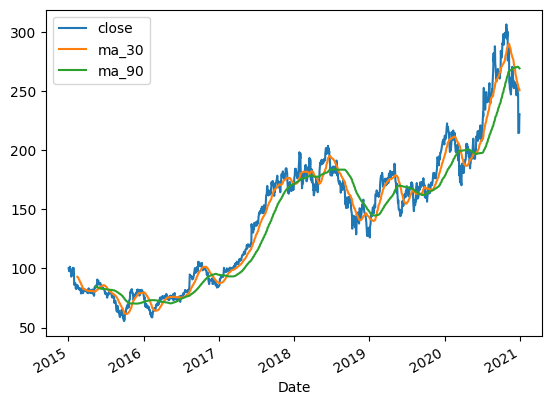

In [5]:
close = tab['Close']
result = pd.concat([close, ma_30, ma_90], axis=1)
result.columns = ['close', 'ma_30', 'ma_90']
result.plot()

In [6]:
sig_buy_day = result[(result['ma_30'] > result['ma_90']) & (result['ma_30'].shift(1) < result['ma_90'].shift(1))]
sig_buy_day = pd.Series(sig_buy_day.index)

In [7]:
sig_sale_day = result[(result['ma_90'] > result['ma_30']) & (result['ma_90'].shift(1) < result['ma_30'].shift(1))]
sig_sale_day = pd.Series(sig_sale_day.index)

In [8]:
stock = pd.DataFrame(index=range(len(sig_buy_day) + len(sig_sale_day)), columns=['date', 'signal', 'num_shares', 'share_price', 'share_value', 'cash'])
for i, date in enumerate(sig_buy_day):
    stock.loc[i, 'date'] = date
    stock.loc[i, 'signal'] = 'sig_buy'
for i, date in enumerate(sig_sale_day):
    stock.loc[i + len(sig_buy_day), 'date'] = date
    stock.loc[i + len(sig_buy_day), 'signal'] = 'sig_sale'
stock['num_shares'] = ''
stock['share_price'] = ''
stock['share_value'] = ''
stock['cash'] = ''
stock = stock.sort_values('date').reset_index(drop=True)
stock['date'] = pd.to_datetime(stock['date'])
for i, row in stock.iterrows():
    date = row['date']
    close_price = round(tab.loc[date, 'Close'],2)
    stock.loc[i, 'share_price'] = close_price
stock.loc[0, 'cash'] = money
stock.loc[0, 'num_shares'] = 0
stock.loc[0, 'share_value'] = 0
if stock.loc[0, 'signal'] == 'sig_sale':
    stock = stock.drop(0)
    stock = stock.reset_index(drop=True)

In [9]:
first_sig_buy_date = stock.loc[stock['signal'] == 'sig_buy', 'date'].iloc[0]
for i, row in stock.iterrows():
    if row['signal'] != 'sig_buy':
        stock.loc[i, 'num_shares'] = 0
        stock.loc[i, 'share_value'] = 0
        stock.loc[i, 'cash'] = money
    else:
        stock.loc[i, 'num_shares'] = 0
        stock.loc[i, 'share_value'] = 0
        stock.loc[i, 'cash'] = money
        next_day = tab[tab.index > first_sig_buy_date].iloc[0].name
        if next_day not in stock['date'].values:
            next_row = pd.Series({'date': next_day, 'signal': 'buy'})
            next_row['share_price'] = round(tab.loc[next_day, 'Open'],2)
            next_row['num_shares'] = int(money / next_row['share_price'])
            next_row['share_value'] = round(next_row['num_shares'] * next_row['share_price'],2)
            next_row['cash'] = money - next_row['share_value']
            stock = pd.concat([stock, pd.DataFrame([next_row])], ignore_index=True)
            break
stock = stock.drop_duplicates(subset='date').sort_values('date').reset_index(drop=True)

In [10]:
buy_index = stock[stock['signal'] == 'buy'].index[0]

for i in range(buy_index, 100):
    try:
        if stock.loc[i, 'signal'] == 'buy':
            buy_date = stock.loc[i, 'date']
            sig_sale_date = stock.loc[i + 1, 'date']
            stop_loss_price = stock.loc[i, "share_price"] * (1 - stop_loss)
            stop_loss_dates = tab[(tab.index > buy_date) & (tab.index < sig_sale_date) & (tab['Low'] < stop_loss_price)]
            stop_open_dates = tab[(tab.index > buy_date) & (tab.index < sig_sale_date) & (tab['Open'] < stop_loss_price)]
        else:
            stop_loss_dates = pd.DataFrame()
            stop_open_dates = pd.DataFrame()

        if not stop_open_dates.empty:
            new_row = pd.Series({
                'date': stop_open_dates.iloc[0].name,
                'signal': 'stop-loss',
                'share_price': round(stop_open_dates.iloc[0]['Open'], 2),
                'num_shares': 0,
                'share_value': 0,
                'cash': round(stock.loc[i, 'cash'] + stock.loc[i, 'num_shares'] * stop_open_dates.iloc[0]['Open'], 2)
            })
            stock = pd.concat([stock.iloc[:i+1], pd.DataFrame([new_row]), stock.iloc[i+1:]], ignore_index=True)

        elif stop_open_dates.empty and not stop_loss_dates.empty:
            new_row = pd.Series({
                'date': stop_loss_dates.iloc[0].name,
                'signal': 'stop-loss',
                'share_price': round(stop_loss_price, 2),
                'num_shares': 0,
                'share_value': 0,
                'cash': round(stock.loc[i, 'cash'] + stock.loc[i, 'num_shares'] * stop_loss_price, 2)
            })
            stock = pd.concat([stock.iloc[:i+1], pd.DataFrame([new_row]), stock.iloc[i+1:]], ignore_index=True)

        elif stop_open_dates.empty and stop_loss_dates.empty:
            if stock.loc[i, 'signal'] == 'sig_sale':
                stock.loc[i, 'num_shares'] = round(stock.loc[i-1, 'num_shares'], 2)
                stock.loc[i, 'share_value'] = round(stock.loc[i, 'share_price'] * stock.loc[i, 'num_shares'], 2)
                stock.loc[i, 'cash'] = round(stock.loc[i-1, 'cash'], 2)
                if stock.loc[i, 'num_shares'] > 0:
                    next_day = tab[tab.index > stock.loc[i, 'date']].iloc[0].name
                    next_row = pd.Series({
                        'date': next_day,
                        'signal': 'sale',
                        'share_price': round(tab.loc[next_day, 'Open'], 2),
                        'num_shares': 0,
                        'share_value': 0,
                        'cash': round(stock.loc[i-1, 'cash'] + stock.loc[i-1, 'num_shares'] * tab.loc[next_day, 'Open'], 2)
                    })
                    next_row['share_value'] = next_row['num_shares'] * next_row['share_price']
                    stock = pd.concat([stock.iloc[:i+1], pd.DataFrame([next_row]), stock.iloc[i+1:]], ignore_index=True)
                else:
                    continue
            elif stock.loc[i, 'signal'] == 'sig_buy':
                stock.loc[i, 'num_shares'] = round(stock.loc[i-1, 'num_shares'], 2)
                stock.loc[i, 'share_value'] = 0
                stock.loc[i, 'cash'] = round(stock.loc[i-1, 'cash'], 2)
                next_day = tab[tab.index > stock.loc[i, 'date']].iloc[0].name
                next_row = pd.Series({
                    'date': next_day,
                    'signal': 'buy',
                    'share_price': round(tab.loc[next_day, 'Open'], 2),
                    'num_shares': int(stock.loc[i-1, 'cash'] / tab.loc[next_day, 'Open']),
                    'share_value': round(tab.loc[next_day, 'Open'] * int(stock.loc[i-1, 'cash'] / tab.loc[next_day, 'Open']), 2),
                    'cash': round(stock.loc[i-1, 'cash'] - int(stock.loc[i-1, 'cash'] / tab.loc[next_day, 'Open']) * tab.loc[next_day, 'Open'], 2)
                })
                next_row['share_value'] = next_row['num_shares'] * next_row['share_price']
                stock = pd.concat([stock.iloc[:i+1], pd.DataFrame([next_row]), stock.iloc[i+1:]], ignore_index=True)

    except KeyError:
        # Если возникает ошибка KeyError, значит, мы вышли за пределы таблицы
        break
stock = stock.drop_duplicates(subset='date').sort_values('date').reset_index(drop=True)
indices_to_drop = []
for i in range(1, len(stock)):
    if stock.loc[i, 'signal'] == 'sig_sale' and stock.loc[i-1, 'signal'] == 'stop-loss':
        indices_to_drop.append(i)

stock = stock.drop(indices_to_drop).reset_index(drop=True)

In [11]:
stock

,date,signal,num_shares,share_price,share_value,cash
0,2015-06-02,sig_buy,0,87.41,0,1000000
1,2015-06-03,buy,11440,87.41,999970.4,29.6
2,2015-06-23,stop-loss,0,83.03,0,949948.85
3,2015-11-09,sig_buy,0,78.59,0,949948.85
4,2015-11-10,buy,12128,78.32,949864.96,59.04
5,2015-11-16,stop-loss,0,73.23,0,888223.56
6,2016-04-07,sig_buy,0,74.95,0,888223.56
7,2016-04-08,buy,11750,75.59,888182.5,53.0
8,2016-05-25,stop-loss,0,71.81,0,843826.38
9,2017-02-09,sig_buy,0,99.8,0,843826.38


In [12]:
final_value = stock.loc[(stock['signal'] == 'sale') | (stock['signal'] == 'stop-loss'), 'cash'].iloc[-1]
print("Итоговая стоимость:", final_value)
print("Процент прироста/падения исходных вложений:",(final_value-money)/money*100)

Итоговая стоимость: 1583061.06
Процент прироста/падения исходных вложений: 58.306106


In [13]:
df = tab.reset_index()

In [14]:
df.rename(columns={'Open': 'open_price'}, inplace=True)

fig = go.Figure(data=go.Ohlc(x=df['Date'],
                             open=df['open_price'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             increasing=dict(line=dict(color='green')),
                             decreasing=dict(line=dict(color='red'))))
fig.add_trace(go.Scatter(x=df['Date'], y=ma_30, name='MA 30'))
fig.add_trace(go.Scatter(x=df['Date'], y=ma_90, name='MA 90'))
buy_dates = stock[stock['signal'] == 'sig_buy']['date']
fig.add_trace(go.Scatter(x=buy_dates, y=ma_30.loc[buy_dates], mode='markers', marker=dict(symbol='triangle-up', color='green',size=10), name='Buy Signal'))
sale_dates = stock[stock['signal'] == 'sig_sale']['date']
fig.add_trace(go.Scatter(x=sale_dates, y=ma_30.loc[sale_dates], mode='markers', marker=dict(symbol='triangle-down', color='red', size=10), name='Sale Signal'))
stop_loss_dates = stock[stock['signal'] == 'stop-loss']['date']
fig.add_trace(go.Scatter(x=stop_loss_dates, y=ma_30.loc[stop_loss_dates], mode='markers', marker=dict(symbol='triangle-down', color='black', size=10), name='Stop Loss'))
fig.show()
